In [57]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetV2L , VGG16, VGG19, InceptionV3, Xception, ResNet101V2, MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from keras.models import Model
import multiprocessing
from tqdm import tqdm
from pytube import YouTube
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, GlobalAveragePooling3D, GlobalMaxPooling3D, TimeDistributed, LSTM, Bidirectional, Attention, Add, Flatten
from tensorflow.keras.layers import Reshape, MaxPooling2D, Conv2D, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomContrast, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness, GlobalAveragePooling1D

In [7]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [8]:
data_dir = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split'
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')

In [9]:
classes = ['Normal', 'Violence', 'Weaponized']
img_width, img_height = 128, 128
frames_per_video = 8
batch_size = 32
channels = 3
epochs = 50

In [10]:
def frames_extraction(video_path, progress_bar=None):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / frames_per_video), 1)
    
    for frame_counter in tqdm(range(frames_per_video), desc=f"Extracting frames from {video_path}", disable=(progress_bar is None)):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (img_height, img_width))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
        if progress_bar:
            progress_bar.update(1)
    video_reader.release()
    return frames_list

In [11]:
def parallel_frame_extraction(video_paths):
    pool = multiprocessing.Pool()
    frames_list = []
    with tqdm(total=len(video_paths), desc="Overall Progress") as pbar:
        for frames in pool.imap_unordered(frames_extraction, video_paths):
            frames_list.append(frames)
            pbar.update(1)
    pool.close()
    pool.join()
    return frames_list

def create_dataset(data_dir):
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(classes):
        print(f'Extracting Data of Class: {class_name}')
        class_dir = os.path.join(data_dir, class_name)
        files_list = os.listdir(class_dir)
        video_paths = [os.path.join(class_dir, file_name) for file_name in files_list]
        
        frames_list = parallel_frame_extraction(video_paths)
        for frames, video_file_path in zip(frames_list, video_paths):
            if len(frames) == frames_per_video:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [12]:
features_train, labels_train, _ = create_dataset(train_dir)
features_test, labels_test, _ = create_dataset(test_dir)

Extracting Data of Class: Normal


Overall Progress: 100%|██████████| 872/872 [01:16<00:00, 11.47it/s]


Extracting Data of Class: Violence


Overall Progress: 100%|██████████| 970/970 [01:21<00:00, 11.83it/s]


Extracting Data of Class: Weaponized


Overall Progress: 100%|██████████| 832/832 [01:07<00:00, 12.31it/s]


Extracting Data of Class: Normal


Overall Progress: 100%|██████████| 169/169 [00:14<00:00, 11.78it/s]


Extracting Data of Class: Violence


Overall Progress: 100%|██████████| 118/118 [00:09<00:00, 12.51it/s]


Extracting Data of Class: Weaponized


Overall Progress: 100%|██████████| 190/190 [00:15<00:00, 12.45it/s]


In [13]:
one_hot_encoded_labels_train = to_categorical(labels_train)
one_hot_encoded_labels_test = to_categorical(labels_test)

In [14]:
print(f"Train data shape: {features_train.shape}, {one_hot_encoded_labels_train.shape}")
print(f"Test data shape: {features_test.shape}, {one_hot_encoded_labels_test.shape}")

Train data shape: (2674, 8, 128, 128, 3), (2674, 3)
Test data shape: (477, 8, 128, 128, 3), (477, 3)


In [15]:
def create_model():
    backbone = ResNet101V2(include_top=False, weights="imagenet")
    backbone.trainable = True
    
    for layer in backbone.layers[:-20]:
        layer.trainable = False
        
    model = Sequential()
    
    model.add(Input(shape=(frames_per_video, img_height , img_width, channels)))  
    
    model.add(TimeDistributed(backbone))
    
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(BatchNormalization()))  

    model.add(Bidirectional(LSTM(128, return_sequences = True)))    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(len(classes), activation='softmax'))
    
    model.summary()
    return model


model = create_model()

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │    42,626,560 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 7,879,680 (30.06 MB)

 Non-trainable params: 34,746,880 (132.55 MB)

In [16]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
plot_model(model, to_file = 'ResNet101LSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [19]:
history = model.fit(
    features_train, 
    one_hot_encoded_labels_train, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(features_test, one_hot_encoded_labels_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.4501 - loss: 1.2784
Epoch 1: val_accuracy improved from -inf to 0.85115, saving model to best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 187s 943ms/step - accuracy: 0.4509 - loss: 1.2765 - val_accuracy: 0.8512 - val_loss: 0.5049 - learning_rate: 0.0010
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6494 - loss: 0.8229
Epoch 2: val_accuracy improved from 0.85115 to 0.97484, saving model to best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 553ms/step - accuracy: 0.6499 - loss: 0.8220 - val_accuracy: 0.9748 - val_loss: 0.2429 - learning_rate: 0.0010
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8248 - loss: 0.4825
Epoch 3: val_accuracy improved from 0.97484 to 1.00000, saving model to best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 551ms/step - accuracy: 0.8251 - loss: 0.4817 - val_accuracy: 1.0000 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │    42,626,560 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │       131,072 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │    33,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,216,715 (611.18 MB)

 Trainable params: 41,801,155 (159.46 MB)

 Non-trainable params: 34,813,248 (132.80 MB)

 Optimizer params: 83,602,312 (318.92 MB)

In [ ]:
model.save("ABC.keras")
model.save_weights('ABC.weights.h5')
model.save('ABC.h5')

In [30]:
def detect_violence(video_path, model):
    cap = cv2.VideoCapture(video_path)
    frames_per_chunk = 8
    chunk_size = frames_per_chunk * img_height * img_width * 3
    violence_frames = []

    while True:
        frames = []
        for _ in range(frames_per_chunk):
            ret, frame = cap.read()
            if not ret:
                cap.release()
                return np.array(violence_frames)

            frame = cv2.resize(frame, (img_height, img_width))
            frames.append(frame)

        if len(frames) != frames_per_chunk:
            break

        frames = np.array(frames)
        frames = frames / 255.0
        prediction = model.predict(np.expand_dims(frames, axis=0))[0]
        if np.argmax(prediction) == 1 or np.argmax(prediction) == 2:
            violence_frames.extend(frames)

    cap.release()
    return np.array(violence_frames)

def generate_video_with_annotations(video_path, frames, class_detected, output_directory):
    filename = os.path.splitext(os.path.basename(video_path))[0] + '_violence_detected.mp4'
    output_path = os.path.join(output_directory, filename)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (frames[0].shape[1], frames[0].shape[0]))

    try:
        for frame in frames:
            frame = (frame * 255).astype(np.uint8)
            cv2.putText(frame, class_detected, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            out.write(frame)
    except Exception as e:
        print("Error during video writing:", e)
    finally:
        out.release()

    return output_path

In [35]:
video_path = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted/Train/Violence/v001_converted.avi'
output_directory = '/kaggle/working'
frames_per_chunk = 8
violence_frames = detect_violence(video_path, model)

if len(violence_frames) > 0:
    violence_frames = np.array(violence_frames, dtype='float32')
    violence_frames = violence_frames.reshape((-1, frames_per_chunk, img_height, img_width, 3))

    predictions = model.predict(violence_frames)
    class_indices = np.argmax(predictions, axis=-1)

    valid_indices = np.where((class_indices >= 0) & (class_indices < len(classes)))[0]
    valid_violence_frames = violence_frames[valid_indices]

    if valid_violence_frames.size > 0:
        class_detected = classes[class_indices[valid_indices[0]]]
        output_video_path = generate_video_with_annotations(video_path, valid_violence_frames.reshape((-1, img_height, img_width, 3)), class_detected, output_directory)
        print("Violence frames detected and annotated in:", output_video_path)
    else:
        print("No valid violence frames detected in the video.")
else:
    print("No violence frames detected in the video.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Violence frames detected 

In [36]:
video_path = '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted/Train/Weaponized/w003_converted.avi'
output_directory = '/kaggle/working'
frames_per_chunk = 8
violence_frames = detect_violence(video_path, model)

if len(violence_frames) > 0:
    violence_frames = np.array(violence_frames, dtype='float32')
    violence_frames = violence_frames.reshape((-1, frames_per_chunk, img_height, img_width, 3))

    predictions = model.predict(violence_frames)
    class_indices = np.argmax(predictions, axis=-1)

    valid_indices = np.where((class_indices >= 0) & (class_indices < len(classes)))[0]
    valid_violence_frames = violence_frames[valid_indices]

    if valid_violence_frames.size > 0:
        class_detected = classes[class_indices[valid_indices[0]]]
        output_video_path = generate_video_with_annotations(video_path, valid_violence_frames.reshape((-1, img_height, img_width, 3)), class_detected, output_directory)
        print("Violence frames detected and annotated in:", output_video_path)
    else:
        print("No valid violence frames detected in the video.")
else:
    print("No violence frames detected in the video.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Violence frames detected and annotated in: /kaggle/working/w003_converted_violence_detected.mp4


In [58]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

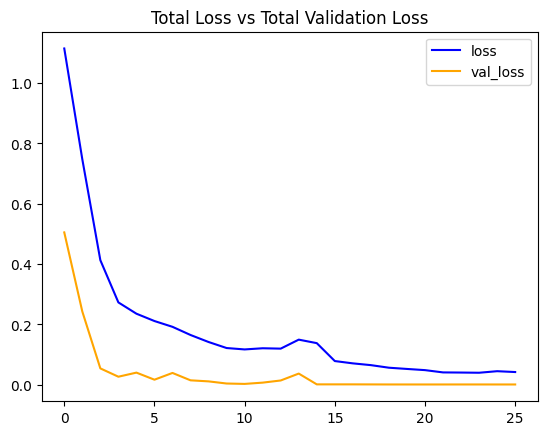

In [59]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

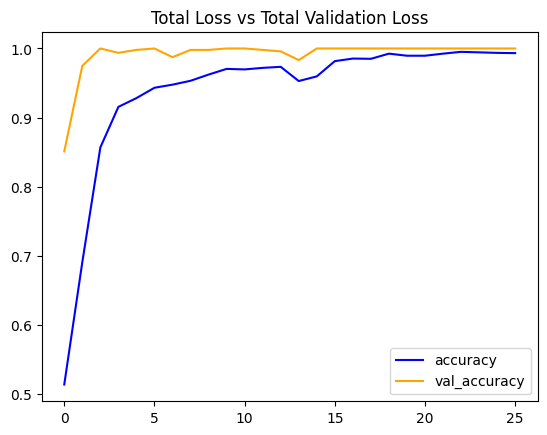

In [60]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [ ]:
import requests

def send_file(file_path, endpoint):
    try:
        with open(file_path, 'rb') as file:
            files = {'file': file}
            response = requests.post(endpoint, files=files)
            if response.status_code == 200:
                print("File uploaded successfully.")
                print(response.text)
            else:
                print(f"Failed to upload file. Status code: {response.status_code}")
    except FileNotFoundError:
        print("File not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    file_path = "/kaggle/working/v001_converted_violence_detected.mp4"
    endpoint = "https://da86-2401-4900-6276-9e66-b40a-202c-1b85-4c9d.ngrok-free.app/upload"
    send_file(file_path, endpoint)

In [63]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)